# Projet 'Température Terrestre'


## 6. Préprocessing des données

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# On part du dataframe préparé auparavant
df=pd.read_csv("./merged_owid_temp_zones.csv", index_col=0)

## Gestion des NaN

In [50]:
display(df.head())
display(df.shape)
df.isna().sum()

,zone_geo,pays,iso_code,continent,year,population,gdp,co2,co2_per_capita,methane,nitrous_oxide,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,temperature
116,11,Canada,CAN,1,1970,21434580.0,4.177520e+11,341.177,15.917,NaN,NaN,0.003,0.012,0.015,0.001,-0.23
117,11,Canada,CAN,1,1971,21888686.0,4.410566e+11,352.287,16.094,NaN,NaN,0.003,0.012,0.016,0.001,-0.05
118,11,Canada,CAN,1,1972,22222228.0,4.643421e+11,380.792,17.136,NaN,NaN,0.003,0.013,0.016,0.001,-1.55
119,11,Canada,CAN,1,1973,22502026.0,4.976174e+11,381.273,16.944,NaN,NaN,0.003,0.013,0.016,0.001,0.50
120,11,Canada,CAN,1,1974,22812430.0,5.179518e+11,389.617,17.079,NaN,NaN,0.003,0.013,0.017,0.001,-0.65


(9339, 16)

zone_geo                          0
pays                              0
iso_code                          0
continent                         0
year                              0
population                       65
gdp                            1773
co2                             315
co2_per_capita                  336
methane                        4051
nitrous_oxide                  4051
temperature_change_from_ch4     192
temperature_change_from_co2     144
temperature_change_from_ghg     144
temperature_change_from_n2o     192
temperature                       0
dtype: int64

In [51]:
# On retire tout de suite certaines mesures qui sont directement liées aux autres (donc pas utiles pour notre Machine Learning)
df = df.drop(["co2_per_capita", "temperature_change_from_ch4","temperature_change_from_co2","temperature_change_from_n2o"], axis= 1)

In [52]:
# ON INTERPOLE LE PIB, LA POPULATION ET LE CO2 QD C'EST POSSIBLE (au sein d'un même pays)
df.reset_index(drop=True, inplace=True)

grouped = df.groupby('iso_code')
df.gdp = grouped['gdp'].apply(lambda x: x.interpolate())
df.population = grouped['population'].apply(lambda x: x.interpolate())
df.co2 = grouped['co2'].apply(lambda x: x.interpolate())


In [53]:
df.isna().sum()

zone_geo                          0
pays                              0
iso_code                          0
continent                         0
year                              0
population                       65
gdp                            1773
co2                             315
methane                        4051
nitrous_oxide                  4051
temperature_change_from_ghg     144
temperature                       0
dtype: int64

In [5]:
#  ON RETIRE TOUTES LES LIGNES SANS INFO CO2
df = df.dropna(subset=['co2'])

In [6]:
df.isna().sum()

zone_geo                          0
pays                              0
iso_code                          0
continent                         0
year                              0
population                       21
gdp                            1500
co2                               0
methane                        3746
nitrous_oxide                  3746
temperature_change_from_ghg       0
temperature                       0
dtype: int64

In [7]:
# Il nous reste beaucoup de NaN pour le PIB. De quel pays s'agit-il ?
df.loc[df.gdp.isna() == True].pays.unique()

array(['Belize', 'Antigua-et-Barbuda', 'Bahamas', 'Grenade',
       'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines',
       'Guyana', 'Suriname', 'Liechtenstein', 'Bélarus', 'Estonie',
       'Lettonie', 'Lituanie', 'Moldova', 'Slovaquie', 'Ukraine',
       'Andorre', 'Érythrée', 'Somalie', 'Soudan du Sud', 'Soudan',
       'Azerbaïdjan', 'Arménie', 'Géorgie', 'Kazakhstan', 'Kirghizistan',
       'Tadjikistan', 'Émirats arabes unis', 'Turkménistan',
       'Ouzbékistan', 'Corée du Nord', 'Brunéi Darussalam', 'Timor-Leste',
       'Bhoutan', 'Maldives', 'Salomon, Îles', 'Fidji', 'Kiribati',
       'Nauru', 'Vanuatu', 'Micronésie, États fédérés de',
       'Marshall, Îles', 'Palaos', 'Papouasie-Nouvelle-Guinée', 'Tonga',
       'Tuvalu', 'Samoa', 'Antarctique'], dtype=object)

In [8]:
# ON RETIRE TOUTES LES LIGNES SANS GDP (sinon, il faudrait faire des recherches car on ne peut pas "générer" l'info)
df = df.dropna(subset=['gdp'])

# ON ELIMINE LES COLONNES MH4 ET N2O afin de garder un nombre de lignes un peu conséquent
df = df.drop(["methane","nitrous_oxide"], axis=1)

In [9]:
df = df.rename(columns={'gdp' :'pib', 'year':'année', 'temperature_change_from_ghg':'delta_T°_dû_aux_ghg'})
display(df.shape)
df.head()

(7524, 10)

,zone_geo,pays,iso_code,continent,année,population,pib,co2,delta_T°_dû_aux_ghg,temperature
0,11,Canada,CAN,1,1970,21434580.0,4.177520e+11,341.177,0.015,-0.23
1,11,Canada,CAN,1,1971,21888686.0,4.410566e+11,352.287,0.016,-0.05
2,11,Canada,CAN,1,1972,22222228.0,4.643421e+11,380.792,0.016,-1.55
3,11,Canada,CAN,1,1973,22502026.0,4.976174e+11,381.273,0.016,0.50
4,11,Canada,CAN,1,1974,22812430.0,5.179518e+11,389.617,0.017,-0.65


### Remarque sur les outliers

In [10]:
# recherche d'outliers
df.describe()

,zone_geo,continent,année,population,pib,co2,delta_T°_dû_aux_ghg,temperature
count,7524.000000,7524.000000,7524.000000,7.524000e+03,7.524000e+03,7524.000000,7524.000000,7524.000000
mean,29.462121,2.705210,1993.906433,3.499371e+07,3.487614e+11,149.827480,0.006423,0.369718
std,10.440734,1.075519,13.719538,1.247401e+08,1.225565e+12,616.376756,0.020510,0.589517
min,11.000000,1.000000,1970.000000,5.440100e+04,1.044400e+08,0.000000,0.000000,-1.910000
25%,22.000000,2.000000,1982.000000,3.029217e+06,1.278969e+10,2.425750,0.001000,-0.020000
50%,31.000000,3.000000,1994.000000,8.020490e+06,4.160595e+10,14.260000,0.001000,0.310000
75%,41.000000,4.000000,2006.000000,2.280383e+07,1.966599e+11,65.788500,0.004000,0.720000
max,51.000000,5.000000,2017.000000,1.410276e+09,1.759628e+13,10011.151000,0.270000,4.660000


In [11]:
%matplotlib inline

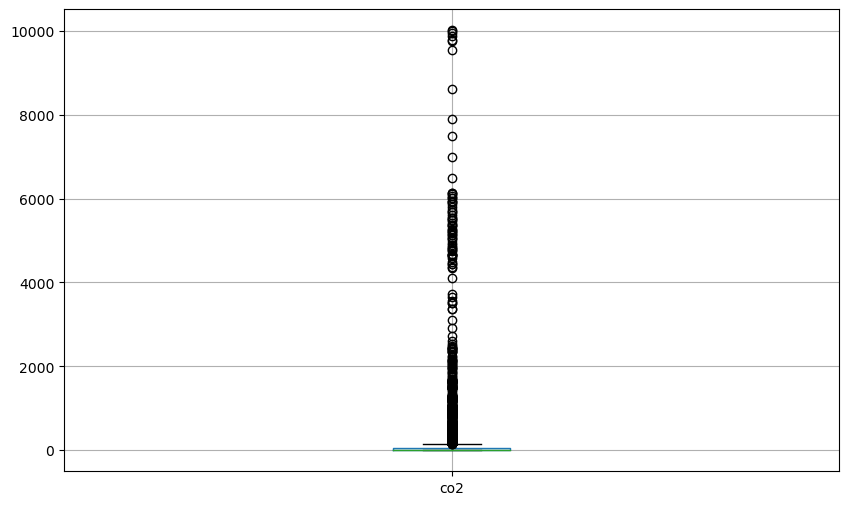

In [12]:
# C'est surtout sur le CO2 qu'on a de gros écarts :
plt.figure(figsize=(10, 6))
df.boxplot(column='co2')
plt.show()

In [13]:
#  A quoi correspondent ces écarts ?
df.loc[df.co2>6000]
#  C'est la Chine et les USA... donc les données sont pertinentes. On les garde

,zone_geo,pays,iso_code,continent,année,population,pib,co2,delta_T°_dû_aux_ghg,temperature
78,11,États-Unis,USA,1,2000,2.823986e+08,1.297384e+13,6010.136,0.227,0.77
81,11,États-Unis,USA,1,2003,2.911098e+08,1.370881e+13,6010.146,0.235,0.94
82,11,États-Unis,USA,1,2004,2.939479e+08,1.422788e+13,6112.655,0.238,0.80
83,11,États-Unis,USA,1,2005,2.968427e+08,1.470373e+13,6132.183,0.241,1.03
84,11,États-Unis,USA,1,2006,2.997531e+08,1.509588e+13,6052.686,0.243,1.07
85,11,États-Unis,USA,1,2007,3.027434e+08,1.536446e+13,6130.123,0.246,0.94
7503,42,Chine,CHN,4,2006,1.313087e+09,9.489544e+12,6494.338,0.112,1.38
7504,42,Chine,CHN,4,2007,1.321513e+09,1.035821e+13,6983.577,0.116,1.66
7505,42,Chine,CHN,4,2008,1.330167e+09,1.079915e+13,7501.498,0.121,1.10
7506,42,Chine,CHN,4,2009,1.339126e+09,1.157254e+13,7891.089,0.126,1.22


## Préparation du jeu de test et du jeu d'apprentissage

In [14]:
# séparation des features et de la target
target = df.temperature
feats = df.drop("temperature", axis=1)

In [15]:
# SPLIT du jeu de test et du jeu d'entrainement
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2, random_state=42)  # , random_state=42

In [16]:
display(X_train.shape)
X_train.columns

(6019, 9)

Index(['zone_geo', 'pays', 'iso_code', 'continent', 'année', 'population',
       'pib', 'co2', 'delta_T°_dû_aux_ghg'],
      dtype='object')

## Encodage et transformation des données

In [17]:
# On sépare les données catégorielles et numériques.
num_cols = ['année','population','pib', 'co2', 'delta_T°_dû_aux_ghg']
cat_cols = ['zone_geo']
num_train = X_train[num_cols]
cat_train = X_train[cat_cols]
num_test = X_test[num_cols]
cat_test = X_test[cat_cols]


In [18]:
# Normalisation des données "années"
# RobustScaler pour les autres données quantitatives vu qu'on n'a pas de loi normale, et qu'on a bcp d'outliers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

column_transformer = ColumnTransformer([
    ('min_max_scaler', MinMaxScaler(), ['année']),
    ('robust_scaler', RobustScaler(), ['population','pib', 'co2', 'delta_T°_dû_aux_ghg'])])

num_train_scaled = column_transformer.fit_transform(X_train)
num_test_scaled = column_transformer.transform(X_test)

In [19]:
# OneHotEncoder pour les zones geo
# vu qu'on a un nb limité de zones géographiques, on peut se permettre le OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
cat_train_encoded = ohe.fit_transform(cat_train)
cat_test_encoded = ohe.transform(cat_test)

In [20]:
# On regroupe nos jeux de données
X_train_processed = pd.concat([pd.DataFrame(num_train_scaled, columns=num_cols),
                               pd.DataFrame(cat_train_encoded, columns=ohe.get_feature_names_out(cat_cols))],
                              axis=1)
X_test_processed = pd.concat([pd.DataFrame(num_test_scaled, columns=num_cols),
                              pd.DataFrame(cat_test_encoded, columns=ohe.get_feature_names_out(cat_cols))],
                             axis=1)


In [21]:
X_train_processed

,année,population,pib,co2,delta_T°_dû_aux_ghg,zone_geo_11,zone_geo_12,zone_geo_13,zone_geo_14,zone_geo_21,...,zone_geo_31,zone_geo_32,zone_geo_33,zone_geo_34,zone_geo_35,zone_geo_41,zone_geo_42,zone_geo_43,zone_geo_44,zone_geo_51
0,0.851064,1.056415,2.677128,2.996908,2.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.787234,-0.208206,-0.003342,-0.110925,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.744681,0.267856,-0.068668,-0.168707,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.021277,-0.058662,-0.151807,-0.196856,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.255319,4.106317,0.225524,-0.075657,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,0.893617,-0.313701,-0.065449,-0.122713,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6015,0.617021,-0.400089,-0.227750,-0.212606,-0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6016,0.914894,2.338601,3.374981,7.172410,4.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6017,0.936170,1.775410,4.439798,2.820584,5.666667,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7. Modélisations par machine learning et prédictions

## Fonctions communes

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve

In [23]:
# FONCTION CALCUL DES SCORES
def scores(model, y_test, y_pred, y_train_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2_train = r2_score(y_train, y_train_pred)
  print(f"\n{model}")
  print(f"MSE: {mse}\nRMSE: {rmse}\nR² sur jeu de test : {r2}\nR² sur jeu d'apprentissage : {r2_train}\nMAE: {mae}")

In [29]:
# FONCTION POUR CALCULER LES RESIDUS
def residus(y_test, y_pred, titre):
    residuals = y_test - y_pred

    # Créer un subplot 2x2 pour les graphiques de résidus pour ce modèle
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    fig.suptitle(titre, fontsize=16)

    # Graphique de dispersion des résidus avec ligne horizontale à y=0
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[0, 0])
    axes[0, 0].set_title("Graphique de Dispersion des Résidus")
    axes[0, 0].set_xlabel("Prédictions")
    axes[0, 0].set_ylabel("Résidus")
    axes[0, 0].axhline(y=0, color='r', linestyle='--')

    # Histogramme des résidus
    sns.histplot(residuals, ax=axes[0, 1], kde=True)
    axes[0, 1].set_title("Histogramme des Résidus")
    axes[0, 1].set_xlabel("Résidus")

    # Comparaison entre les Valeurs Réelles et Prédites avec ligne diagonale en rouge
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[1, 0])
    axes[1, 0].set_title("Comparaison Valeurs Réelles vs. Prédites")
    axes[1, 0].set_xlabel("Valeurs Réelles")
    axes[1, 0].set_ylabel("Prédictions")
    axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')

    # QQ plot des résidus
    stats.probplot(residuals, plot=axes[1, 1])
    axes[1, 1].set_title("QQ Plot des Résidus")
    axes[1, 1].set_xlabel("Quantiles théoriques")
    axes[1, 1].set_ylabel("Quantiles empiriques")
      
    # Afficher le subplot
    plt.show()


In [30]:
# FONCTION POUR TRACER LA LEARNING CURVE
def plot_learning_curve(model, X, y, titre):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label="Score d'apprentissage", color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
    plt.plot(train_sizes, test_mean, label='Score de Cross-Validation', color='orange')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)

    # Add labels and title
    plt.xlabel("Taille du jeu d'apprentissage")
    plt.ylabel("Erreur quadratique")
    plt.title(titre)
    plt.legend()
    plt.show()


In [31]:
# FONCTION POUR AFFICHER LES IMPORTANCES (cas d'un arbre)
# Quelles sont les features les plus pertinentes pour le modèle choisi ?
def importances(model,X_train_processed, titre):
    feat_importances = pd.DataFrame(model.feature_importances_, index=X_train_processed.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances = feat_importances.head(10)
    ax = feat_importances.plot(kind='bar', figsize=(10,6))
    ax.set_title(titre)
    plt.show()

In [32]:
# Fonction pour afficher les n premieres valeurs prédites en même temps que les valeurs attendues
def apercuRes(y_pred,y_test,n):
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(0,n),y_pred[:n], color='blue', label='Prediction')
    plt.scatter(np.arange(0,n),y_test[:n], color='red', label='Valeur attendue')

    plt.title('Comparaison entre les premières valeurs prédites et leurs valeurs attendues')
    plt.legend()
    plt.show()

## Test d'un modèle : LinearRegressor

In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
y_train_pred = model.predict(X_train_processed)

scores(model, y_test, y_pred, y_train_pred)




LinearRegression()
MSE: 0.19838136305630258
RMSE: 0.44540022794819334
R² sur jeu de test : 0.42966945955631153
R² sur jeu d'apprentissage : 0.39827875261443146
MAE: 0.33413413589043217


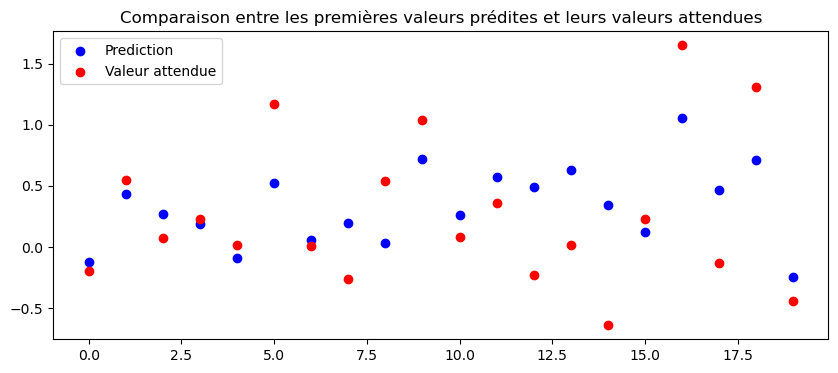

In [29]:
apercuRes(y_pred,y_test,20)

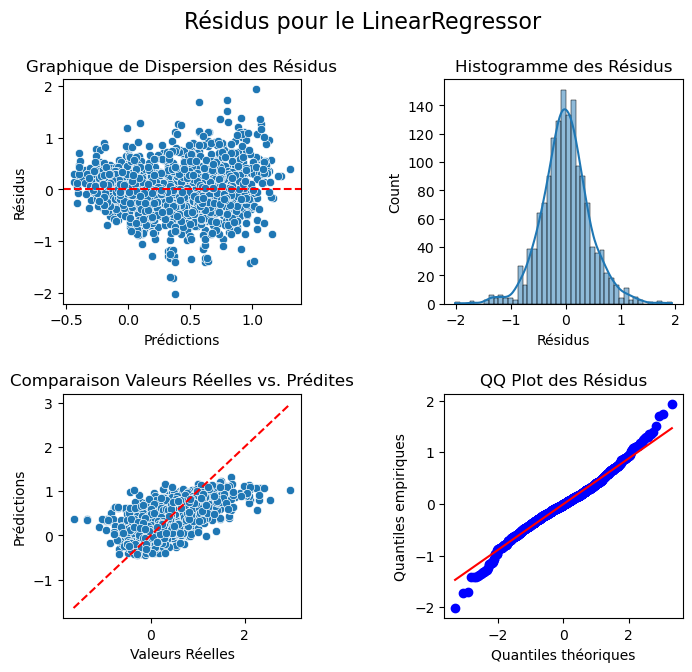

In [30]:
residus(y_test, y_pred, 'Résidus pour le LinearRegressor')

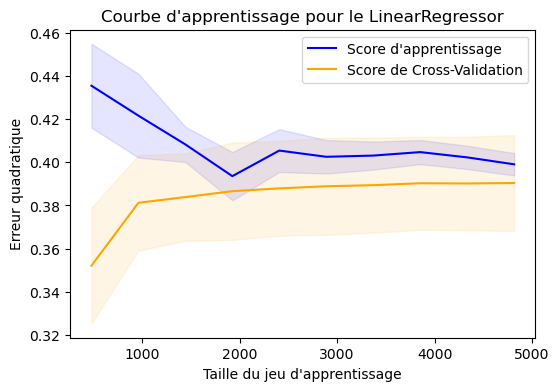

In [31]:
plot_learning_curve(model, X_train_processed, y_train,"Courbe d'apprentissage pour le LinearRegressor")

## ## Test d'un modèle : DecisionTreeRegressor

In [32]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train_processed,y_train)

#prediction sur notre jeu de test
y_pred =model.predict(X_test_processed)
y_train_pred = model.predict(X_train_processed)

scores(model, y_test, y_pred, y_train_pred)


DecisionTreeRegressor()
MSE: 0.22279973421926907
RMSE: 0.47201666731087905
R² sur jeu de test : 0.35946859689676436
R² sur jeu d'apprentissage : 1.0
MAE: 0.3334750830564784


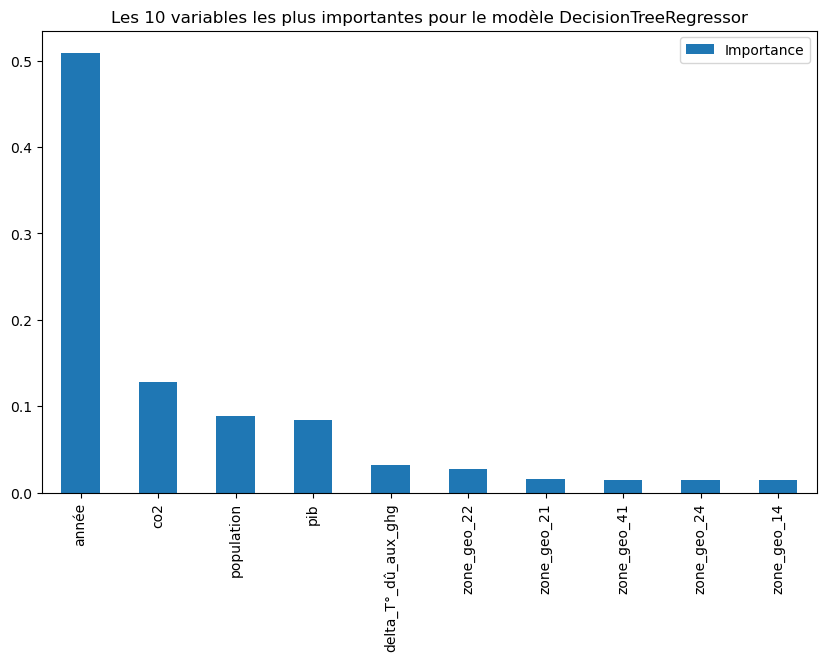

In [33]:
importances(model,X_train_processed, "Les 10 variables les plus importantes pour le modèle DecisionTreeRegressor")

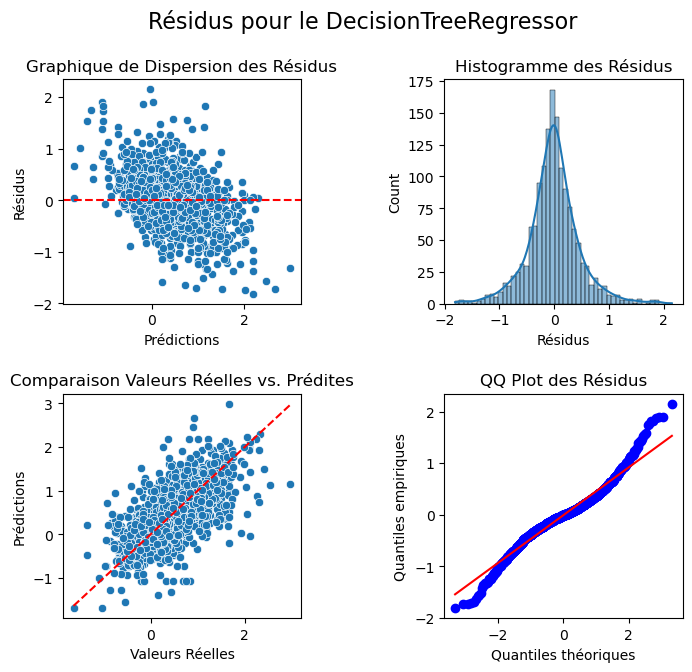

In [34]:
residus(y_test, y_pred, 'Résidus pour le DecisionTreeRegressor')

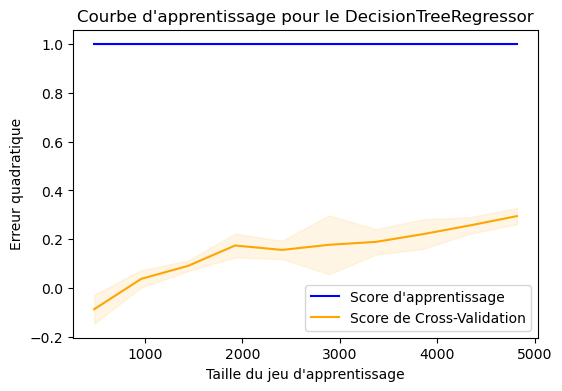

In [35]:
plot_learning_curve(model, X_train_processed, y_train,"Courbe d'apprentissage pour le DecisionTreeRegressor")

## Test d'un modele : RandomForestRegressor

In [33]:
# Choix d'un modèle d'apprentissage et entrainement
#  RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

In [34]:
# GRIDSEARCH
# param_grid = {'n_estimators': np.arange(10,310,30), 'max_depth': np.arange(3, 15, 3)}

# model = RandomForestRegressor()
# model_gs = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring='r2')
# model_gs.fit(X_train_processed, y_train)
# print(model_gs.best_params_)

# Resultat du grid search : (n_estimators=280, max_depth=12)

In [35]:
# model = RandomForestRegressor(n_estimators=280, max_depth=12)
# model = RandomForestRegressor(n_estimators=100, max_depth=5)
model = RandomForestRegressor()
model.fit(X_train_processed,y_train)


RandomForestRegressor()

In [36]:
#prediction sur notre jeu de test
y_pred =model.predict(X_test_processed)
y_train_pred= model.predict(X_train_processed)

scores(model, y_test, y_pred, y_train_pred)


RandomForestRegressor()
MSE: 0.12490639722923588
RMSE: 0.35342099149489675
R² sur jeu de test : 0.6409041054103146
R² sur jeu d'apprentissage : 0.9451959432552037
MAE: 0.2522926910299004


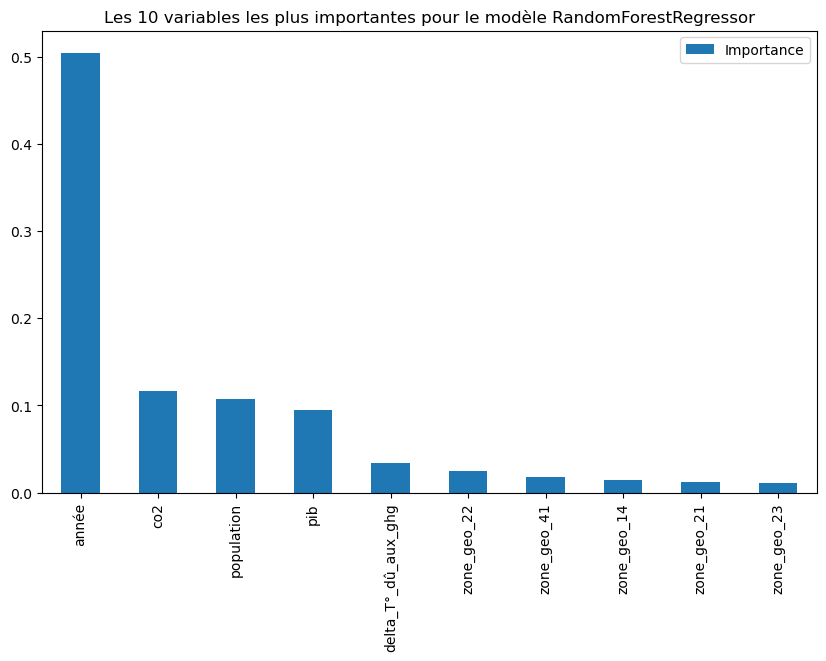

In [37]:
importances(model,X_train_processed, "Les 10 variables les plus importantes pour le modèle RandomForestRegressor")

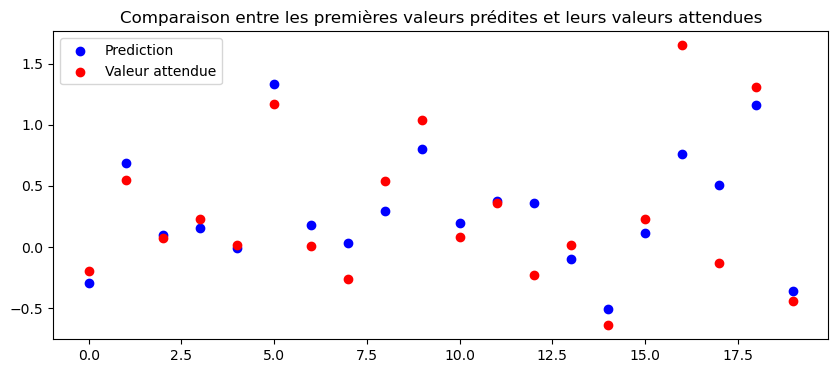

In [41]:
apercuRes(y_pred,y_test,20)

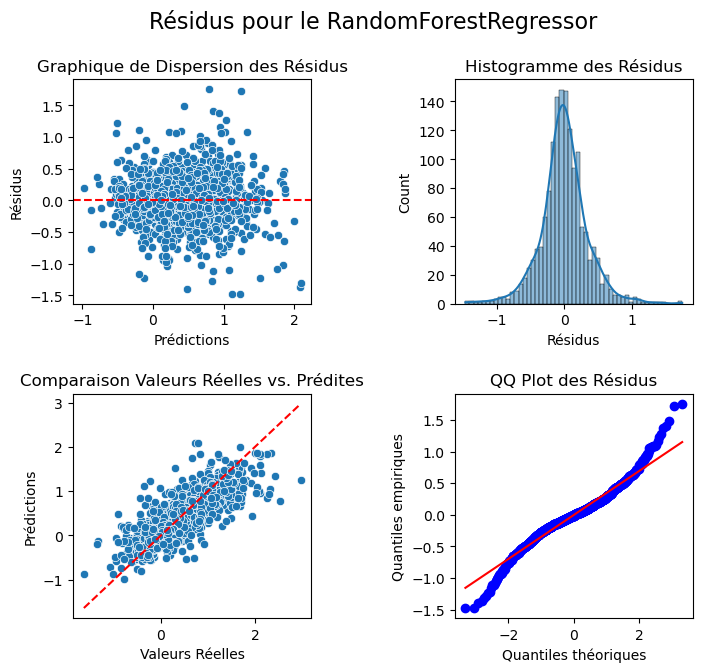

In [38]:
residus(y_test, y_pred, 'Résidus pour le RandomForestRegressor')

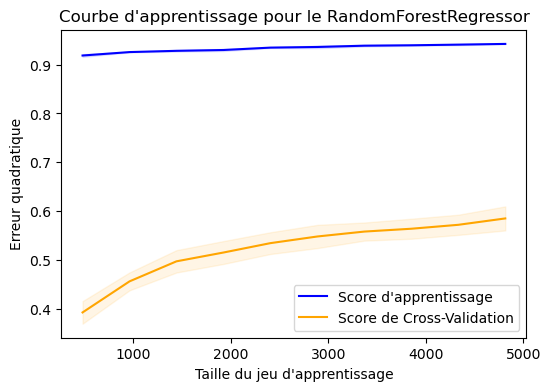

In [39]:
plot_learning_curve(model, X_train_processed, y_train,"Courbe d'apprentissage pour le RandomForestRegressor")

## Test d'un modele : XGBoostRegressor




In [48]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 991.0 kB/s eta 0:01:41
   ---------------------------------------- 0.2/99.8 MB 2.0 MB/s eta 0:00:51
   ---------------------------------------- 0.2/99.8 MB 1.8 MB/s eta 0:00:57
   ---------------------------------------- 0.4/99.8 MB 2.1 MB/s eta 0:00:48
   ---------------------------------------- 0.5/99.8 MB 2.2 MB/s eta 0:00:46
   ---------------------------------------- 0.6/99.8 MB 2.2 MB/s eta 0:00:46
   ---------------------------------------- 0.8/99.8 MB 2.3 MB/s eta 0:00:44
   ---------------------------------------- 0.9/99.8 MB 2.4 MB/s eta 0:00:42
   ---------------------------------------- 1.0/99.8 MB 2.4 MB/s eta 0:00:41
   ---------------------------

In [41]:
# Choix d'un modèle d'apprentissage et entrainement
#  eXtreme Gradient BOOST REGRESSOR
import xgboost as xgb
from xgboost import XGBRegressor

In [42]:
# param_grid = {
#     'n_estimators': [300],
#     'learning_rate': [0.05],
#     'max_depth': [7, 9],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.3],
#     # 'subsample': [0.8, 0.9, 1.0],
#     # 'colsample_bytree': [0.8, 0.9, 1.0],
#     # 'reg_alpha': [0, 0.1, 0.5],
#     # 'reg_lambda': [0, 0.1, 0.5]
# }

# model = xgb.XGBRegressor()
# model_gs = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring='r2')
# model_gs.fit(X_train_processed, y_train)
# print(model_gs.best_params_)

# param_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1],'max_depth': [3, 5, 7]} donne : {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}
#  param_grid = {'n_estimators': [300,400, 500], 'learning_rate': [0.05], 'max_depth': [7, 9, 11, 13]} donne : {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300}
# param_grid = {'n_estimators': [300], 'learning_rate': [0.05], 'max_depth': [7, 9], 'min_child_weight': [1, 3, 5], 'gamma': [0, 0.1, 0.3]} donne : {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300}

In [43]:
# model = xgb.XGBRegressor()
# model = xgb.XGBRegressor(n_estimators=300, max_depth=7, learning_rate=0.05)
model = xgb.XGBRegressor(n_estimators=300, max_depth=9, learning_rate=0.05)
model.fit(X_train_processed,y_train)

#prediction sur notre jeu de test
y_pred = model.predict(X_test_processed)
y_train_pred= model.predict(X_train_processed)

scores(model, y_test, y_pred, y_train_pred)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
MSE: 0.11614130861407736
RMSE: 0.3407951123682342
R² sur jeu de test : 0.6661030336256704
R² sur jeu d'apprentissage : 0.9340975923711917
MAE: 0.24869652912297757


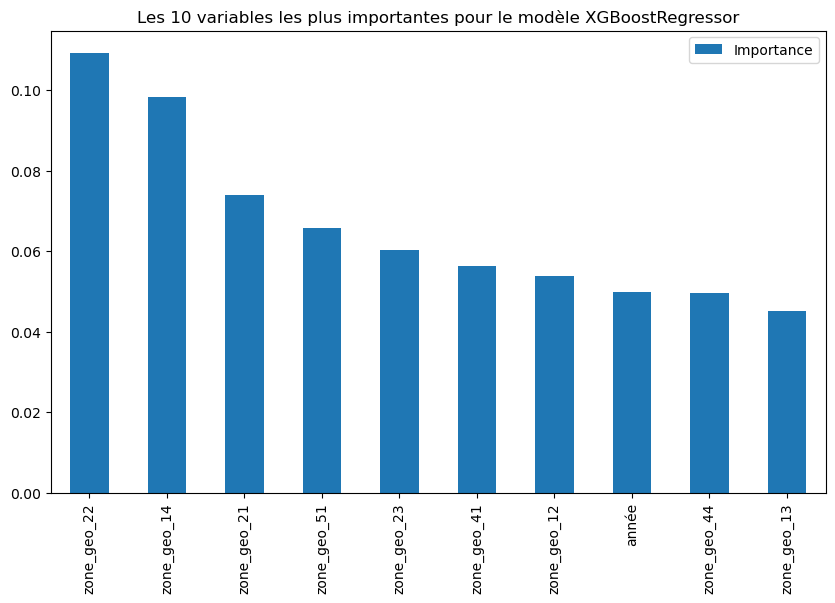

In [44]:
importances(model,X_train_processed, "Les 10 variables les plus importantes pour le modèle XGBoostRegressor")

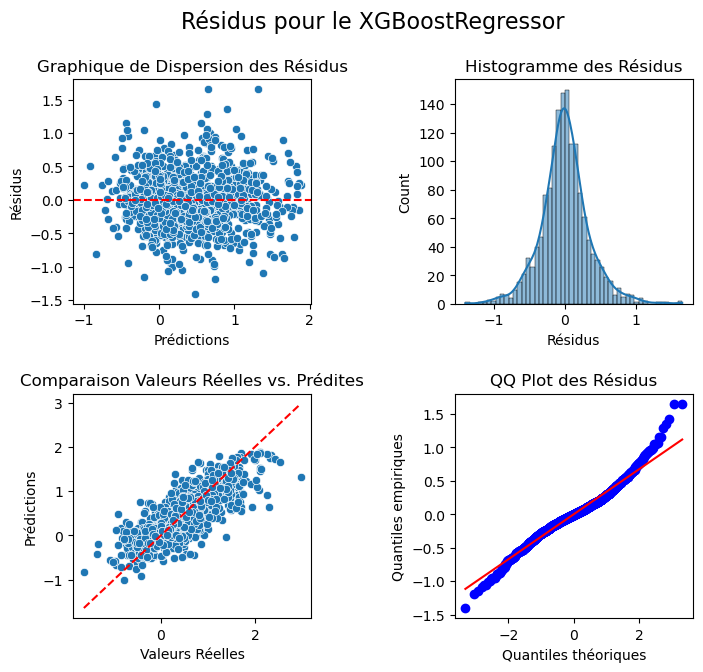

In [45]:
residus(y_test, y_pred, 'Résidus pour le XGBoostRegressor')

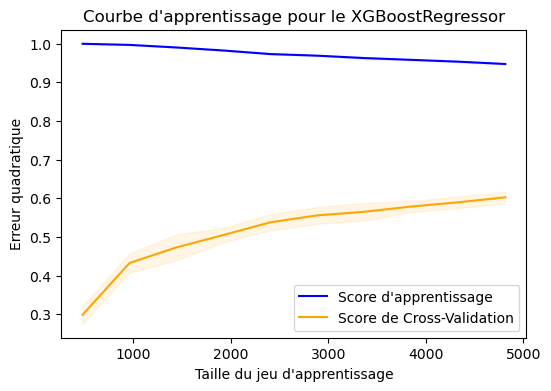

In [46]:
plot_learning_curve(model, X_train_processed, y_train, "Courbe d'apprentissage pour le XGBoostRegressor")